## Reverse Regression on GTEx to calculate Q-scores

This notebook contains a minimal implementation of the reverse regression method. We apply the method on Adipose Subcutaneous tissue in GTEx v8 for 200 SNPs in chr1. 

#### Note: Running this notebook requires access to preprocessed GTEx data.

For 200 SNPs over a range of MAFs, we compare analytical calculations of $\mu_q$ and $\sigma_q$ with their empirical values.
For each of those SNPs, we shuffle the genotype multiple times to obtain empirical $\mu_q$ and $\sigma_q$.

In [1]:
import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
f_gx = "/scratch/sbanerj/trans-eqtl/input/gtex_v8/expression/gtex_as_raw_std_protein_coding_lncRNA.txt"
f_vcf = "/scratch/sbanerj/trans-eqtl/input/gtex_v8/genotype/all_samples/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze_SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr1.vcf.gz"
f_gtf = "/scratch/sbanerj/data/GENCODE/gencode.v26.annotation.gtf.gz"
nread = 5000
nchoose = 200

In [3]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()


def read_gtex(rpkmfile):
    expr_list = list()
    donor_list = list()
    gene_list = list()
    with open(rpkmfile) as mfile:
        donor_list = mfile.readline().strip().split("\t")[1:]
        for line in mfile:
            linesplit = line.strip().split("\t")
            gene = linesplit[0].strip()
            gene_list.append(gene)
            expr = np.array([float(x) for x in linesplit[1:]])
            expr_list.append(expr)
    expr_list = np.transpose(np.array(expr_list))
    expr = np.transpose(np.array(expr_list)) ## see line 137 of iotools/readRPKM.py
    return expr, gene_list, donor_list

def read_vcf(filename, startsnp, endsnp):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith('chr'):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    #dsindx = linesplit[8].split(':').index("DS")
                    #ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                    #gtindx = linesplit[8].split(':').index("GT")
                    #for i, x in enumerate(ds):
                    #    if x == ".":
                    #        gt = linesplit[9+i].split(':')[gtindx]
                    #        if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                    #            ds[i] = float(int(gt[0]) + int(gt[2]))
                    gtindx = linesplit[8].split(':').index("GT")
                    gt = [x.split(':')[gtindx] for x in linesplit[9:]]
                    ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]                    

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                if linenum > endsnp: break
                linenum += 1

    return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

In [4]:
from sklearn.decomposition import PCA

def knn_correction(expr, dosage, K, f=0.1):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]) )
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtcent

In [5]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) \
                    + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) \
                    + v22*(q2**2 + 2*q22 - 3*q4) \
                    + 4*v31*(q31 - q4) \
                    + mu4*q4
    
    sigma2 = sigma2 - muQ**2

    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [6]:
def format_matrix(header, matrix, rownames,
                  top_format, left_format, cell_format, row_delim, col_delim):
    table = [[''] + header] + [[name] + row for name, row in zip(rownames, matrix)]
    table_format = [['{:^{}}'] + len(header) * [top_format]] \
                 + len(matrix) * [[left_format] + len(header) * [cell_format]]
    col_widths = [max(
                      len(format.format(cell, 0))
                      for format, cell in zip(col_format, col))
                  for col_format, col in zip(zip(*table_format), zip(*table))]
    return row_delim.join(
               col_delim.join(
                   format.format(cell, width)
                   for format, cell, width in zip(row_format, row, col_widths))
               for row_format, row in zip(table_format, table))

In [7]:
gtfull, snp_info, gt_donors = read_vcf(f_vcf, 0, nread)

In [8]:
maflist = np.array([x.maf for x in snp_info])
snpindices = random.sample(list(range(nread)), nchoose)
snpindices.sort()

In [9]:
#### Look at the MAF of the selected SNPs.

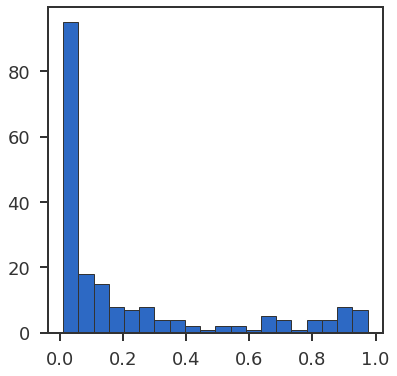

In [10]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.hist(maflist[snpindices])
plt.show()

In [11]:
gx_full, _, gx_donors = read_gtex(f_gx)

In [12]:
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
gx_norm = normalize_expr(gx_full[:, exprmask])
gtmask = gtfull[:, vcfmask]
gt_cent = normalize_and_center_dosage(gtmask, snp_info)
sigmax2 = np.var(gt_cent, axis = 1)

In [13]:
nsample = gx_norm.shape[1]

gx_corr, gt_corr = knn_correction(gx_norm.T, gtmask, 30)
gx_knn = normalize_expr(gx_corr.T) #/ np.sqrt(nsample)
gt_knn = normalize_and_center_dosage(gt_corr, snp_info)

In [14]:
def empirical_shuffling(GX, GT, snpindices, sigmabeta = 0.1, niter = 250):
    sigmabeta2 = sigmabeta * sigmabeta
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    muQlist = list()
    sigmaQlist = list()
    muQemprlist = list()
    sigmaQemprlist = list()
    
    for ix in snpindices:
        mGT = GT[ix, :]
        sigmax2 = np.var(mGT)
        S2mod = S2 + sigmax2 / sigmabeta2
    
        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
        Qscore = np.sum(np.square(np.dot(U.T, mGT)) * S2 / S2mod) / sigmax2
        pval, muQ, sigmaQ = pvals_perm(mGT.reshape(1, -1), Qscore, W)
    
        Qiter = np.zeros(niter)
        permgt = mGT.copy()
        for j in range(niter):
            np.random.shuffle(permgt)
            Qiter[j] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod) / sigmax2
        muQ_empr = np.mean(Qiter)
        sigmaQ_empr = np.std(Qiter)
        
        muQlist.append(muQ)
        sigmaQlist.append(sigmaQ)
        muQemprlist.append(muQ_empr)
        sigmaQemprlist.append(sigmaQ_empr)
        
    return np.array(muQlist), np.array(muQemprlist), np.array(sigmaQlist), np.array(sigmaQemprlist)

In [20]:
muQ, muQ_empr, sigmaQ, sigmaQ_empr = empirical_shuffling(gx_knn, gt_knn, snpindices, sigmabeta = 0.01, niter = 500)

#### Are the mean and variance correctly estimated?

Shuffle the genotype and calculate Q-score 250 times. Compare the mean and variance of these empirical Q-scores with the analytical values obtained from our method.

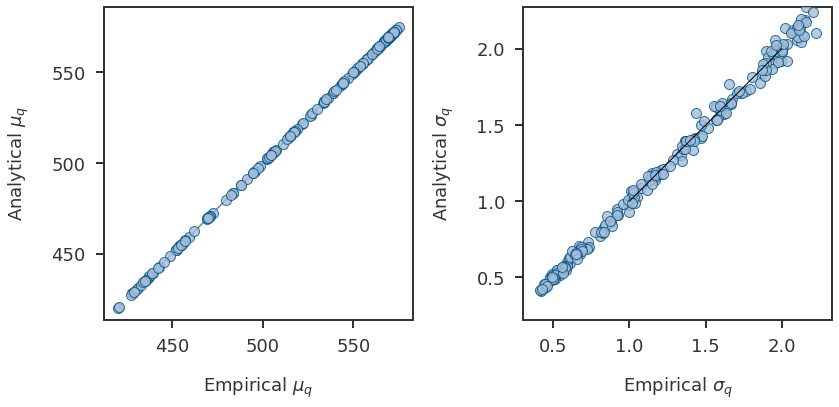

In [77]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

xval = muQ
yval = muQ_empr
fact = 10

ax1.scatter(xval, yval, s=100, edgecolor = '#00538A', color = '#A6BDD7', zorder = 10, alpha = 0.8)
xmax = np.ceil(max(np.max(xval), np.max(yval)) / fact) * fact - fact
xmin = np.floor(min(np.min(xval), np.min(yval)) / fact) * fact + fact
ax1.set_xlim(xmin - fact, xmax + fact)
ax1.plot([xmin, xmax], [xmin, xmax], color = 'gray', zorder = 5)
ax1.axis('equal')
ax1.set_yticks(ax1.get_xticks())
ax1.set_xlabel('Empirical $\mu_q$')
ax1.set_ylabel('Analytical $\mu_q$')

xval = sigmaQ
yval = sigmaQ_empr
fact = 1

ax2.scatter(xval, yval, s=100, edgecolor = '#00538A', color = '#A6BDD7', zorder = 10, alpha = 0.8)
xmax = np.ceil(max(np.max(xval), np.max(yval)) / fact) * fact - fact
xmin = np.floor(min(np.min(xval), np.min(yval)) / fact) * fact + fact
ax2.set_xlim(xmin - fact, xmax + fact)
ax2.plot([xmin, xmax], [xmin, xmax], color = 'black', lw = 1, zorder = 15)
ax2.axis('equal')
ax2.set_yticks(ax2.get_xticks())
ax2.set_xlabel('Empirical $\sigma_q$')
ax2.set_ylabel('Analytical $\sigma_q$')


plt.tight_layout()
plt.show()

In [71]:
data_arr = np.zeros((nchoose, 4))
data_arr[:, 0] = muQ
data_arr[:, 1] = muQ_empr
data_arr[:, 2] = sigmaQ
data_arr[:, 3] = sigmaQ_empr
np.savetxt("muQ_sigmaQ_check.txt", data_arr)